# ChatGPT使用指南——相似匹配

## 1. 何为Embedding

&emsp;&emsp;对于自然语言，因为它的输入是一段文本，在中文里就是一个一个字，或一个一个词，行业内把这个字或词叫Token。如果要使用模型，拿到一段文本的第一件事就是把它Token化，当然，可以按字、也可以按词，或按你想要的其他方式，比如每两个字一组（Bi-Gram）。举个例子：

- 给定文本：我们相信AI可以让世界变得更美好。
- 按字Token化：我/们/相/信/A/I/可/以/让/世/界/变/得/更/美/好/。
- 按词Token化：我们/相信/AI/可以/让/世界/变得/更/美好/。
- 按Bi-Gram Token化：我们/们相/相信/信A/AI/I可/可以/以让/让世/世界/界变/变得/得更/更美/美好/好。

&emsp;&emsp;那自然就有一个新的问题：我们应该怎么选择Token化方式？其实每种不同的方法都有自己的优点和不足，在大模型之前，按词的方式比较常见。但在有了大模型之后，基本都是按字来了，不用再纠结这个点了。

&emsp;&emsp;Token化后，第二件事就是要怎么表示这些Token，我们知道计算机只能处理数字，所以要想办法把这些Token给变成计算机「认识」的数字才行。读者不妨思考一下如果要你来做这件事会怎么做。

&emsp;&emsp;其实很简单很直观，把所有字作为一个字典，序号就代表它自己。我们还是以上面的句子为例，假设词表就包含上面那些字，那么词表就可以用一个txt文件存储，内容如下：

```text
我
们
相
信
A
I
可
以  
让  
世  
界  
变  
得  
更  
美  
好  
。 
```

&emsp;&emsp;一行一个字，每个字作为一个Token，此时，0=我，1=们，……，以此类推。拿中文来说，这个词表可能只要几千行，即使包含各种特殊符号、生僻字，也就2万个多点，我们假设词表大小为N。

&emsp;&emsp;接下来我们考虑如何用这些数字来表示一段文本。最简单的方法就是用它的ID直接串起来，这样也不是不行，但这种表示方法的特征是一维的，也就是说只能表示一个特征。这种方法不太符合实际情况，效果也不理想。所以，研究人员就想到另一种表示方法：One-Hot编码。其实，将文本变为数字表示的过程本质上就是一种编码过程。One-Hot的意思是，对每一个字都有N（词表大小）个特征，除了该字的ID位置值为1，其余都为0。我们依然用上面的例子来说明，把整个词表表示为下面的形式：


> 我 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  
们 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0  
相 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0  
信 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0  
……下面省略

&emsp;&emsp;此时，对每一个Token（字），它的表示就变成了一个一维向量，比如「我」：`[1,0,...0]`，这个向量的长度就是词表的大小N，它被称为「我」这个字的One-Hot表示。

&emsp;&emsp;对于一段文本，我们一般会将每个Token的表示结合起来，结合方式可以采用求和或平均。这样，对于任意长度的任意文本，我们都能将其表示为固定大小的向量，非常方便进行各种矩阵或张量（三维以上的数组）计算，这对深度学习至关重要。

&emsp;&emsp;举个例子，比如有这么一句话：让世界更美好。现在我们使用刚刚的方法将其表示为一个向量，采用平均的方式。

&emsp;&emsp;首先，列出每个字的向量：

> 让 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0  
世 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0  
界 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0  
更 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0  
美 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0  
好 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0  
。 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1  

&emsp;&emsp;然后针对每一列取平均，结果为：`0 0 0 0 0 0 0 1/7 1/7 1/7 0 0 1/7 1/7 1/7 1/7`。不难发现，对任两句话，只要其中包含的字不完全一样，最终得到的向量表示也不会完全一样。注①

&emsp;&emsp;当然，在实际使用时，往往不会这么简单的用1/0来表示，因为每个字在句子中的作用是不一样的，所以一般会给不同的Token赋予不同的权重。最常见的方法是使用在句子中出现的频率，那些高频的（但不是「的」「更」这样的虚词）被认为是重要的。更多可以参考【相关文献1】。

&emsp;&emsp;这种方法不错，在深度学习之前很长一段时间里都是这样的，不过它有两个很大的问题：

1. 数据维度太高：太高的维度会导致向量在空间中聚集在一个非常狭窄的角落，模型难以训练。
2. 数据稀疏，向量之间缺乏语义上的交互（语义鸿沟）：比如「我爱吃苹果」和「我爱用苹果」，前者是水果，后者是手机，怎么判断出来的呢？根据上下文。但由于现在这种表示方式，导致上下文之间是孤立的，所以模型学不到这个知识点。还有类似「我喜欢你」和「你喜欢我」这样会得到同样的表示，但其实是不同的意思。注①


更多可以参考【相关文献 1】。

&emsp;&emsp;终于轮到我们的主角Embedding登场了，它的主要思想是这样的：

- 把特征固定在某一个维度D，比如256、300、768等等，这个不重要，总之不再是词表那么大的数字。这就避免了维度过高的问题。
- 利用自然语言文本的上下文关系学习一个稠密表示。也就是说，每个Token的表示不再是预先算好的了，而是在过程中学习到的，元素也不再是很多个0，而是每个位置都有一个小数，这D个小数构成了一个Token表示。至于D个特征到底是什么，不知道，也不重要。我们只需要知道这D个小数就表示这个Token。

&emsp;&emsp;还是继续以前面的例子来说明，这时候词表的表示变成下面这样了：


> 我 0.xxx0, 0.yyy0, 0.zzz0, ... D个小数  
们 0.xxx1, 0.yyy1, 0.zzz1, ... D个小数  
相 0.xxx2, 0.yyy2, 0.zzz2, ... D个小数  
信 0.xxx3, 0.yyy3, 0.zzz3, ... D个小数  
……下面省略  

&emsp;&emsp;这些小数怎么来的？简单，随机来的。就像下面这样：

In [3]:
import numpy as np

In [12]:
rng = np.random.default_rng(42)
# 词表大小N=16，维度D=256
table = rng.uniform(size=(16, 256))
table.shape

(16, 256)

In [13]:
table

array([[0.77395605, 0.43887844, 0.85859792, ..., 0.24783956, 0.23666236,
        0.74601428],
       [0.81656876, 0.10527808, 0.06655886, ..., 0.11585672, 0.07205915,
        0.84199321],
       [0.05556792, 0.28061144, 0.33413004, ..., 0.00925978, 0.18832197,
        0.03128351],
       ...,
       [0.50647331, 0.22303613, 0.94414565, ..., 0.79202324, 0.40169878,
        0.72247782],
       [0.9151384 , 0.80071297, 0.39044651, ..., 0.03994193, 0.79502741,
        0.28297954],
       [0.68255979, 0.64272531, 0.65262805, ..., 0.18645529, 0.21927175,
        0.32320729]])

&emsp;&emsp;在模型训练过程中，会根据不同的上下文不断地更新这个参数，最后模型训练完后得到的这个矩阵就是Token的表示。我们完全可以把它当成一个黑盒子，输入一个X，根据标签Y不断更新参数，最终就得到一组参数，这些参数的名字就叫「模型」。

&emsp;&emsp;这种表示方法在深度学习早期（2013-2015年左右）比较流行，不过由于这个矩阵训练好后就固定不变了，这在有些时候就不合适。比如「你好坏」这句话在不同的情况下可能完全是不同的意思。

&emsp;&emsp;我们知道，句子才是语义的最小单位，因此相比Token，我们其实更加关注和需要句子的表示，我们期望可以根据不同上下文动态地获得句子表示。这中间当然经历了比较多的探索，一直到如今的大模型时代，对模型输入任意一句话，它都能给我们返回一个非常不错的表示，而且依然是固定长度的向量。

&emsp;&emsp;如果对这方面感兴趣，可以进一步阅读【相关文献2】和【相关文献3】。

&emsp;&emsp;我们总结一下，Embedding本质就是一组稠密向量，用来表示一段文本（可以是字、词、句、段等），获取到这个表示后，我们就可以进一步做一些任务。大家不妨先思考一下，当给定任意句子并获得到它的固定长度的语义表示时，我们可以干什么？我们在下一节将先介绍一下OpenAI提供的接口，以及一些后面任务可能用到的概念。

## 2. 相关API

### 2.1 LMAS Embedding API

In [7]:
import openai
OPENAI_API_KEY = "填入专属的API key"
openai.api_key = OPENAI_API_KEY

In [4]:
text = "我喜欢你"
model = "text-embedding-ada-002"

In [41]:
emb_req = openai.Embedding.create(input=[text], model=model)

In [42]:
emb = emb_req.data[0].embedding
len(emb), type(emb)

(1536, list)

&emsp;&emsp;与Embedding息息相关的一个概念是「相似度」，准确来说是「语义相似度」。在自然语言处理领域，我们一般使用**cosine相似度**作为语义相似度的度量，评估两个向量在语义空间上的分布情况。

&emsp;&emsp;具体来说就是下面这个式子：

$$
\text{cosine}(v,w) = \frac {v·w}{|v||w|} = \frac {\displaystyle \sum_{i=1}^N v_iw_i} {\displaystyle \sqrt{\sum_{i=1}^N v_i^2} \sqrt{\sum_{i=1}^N w_i^2}}
$$

&emsp;&emsp;我们举个例子：

In [27]:
import numpy as np
a = [0.1, 0.2, 0.3]
b = [0.2, 0.3, 0.4]
cosine_ab = (0.1*0.2+0.2*0.3+0.3*0.4)/(np.sqrt(0.1**2+0.2**2+0.3**2) * np.sqrt(0.2**2+0.3**2+0.4**2))
cosine_ab

0.9925833339709301

&emsp;&emsp;OpenAI官方提供了一个集成接口，使用起来更加简单（但其实你也可以自己写一个）：

In [7]:
from openai.embeddings_utils import get_embedding, cosine_similarity

In [16]:
# 注意它默认的模型是text-similarity-davinci-001，我们也可以换成text-embedding-ada-002
text1 = "我喜欢你"
text2 = "我钟意你"
text3 = "我不喜欢你"
emb1 = get_embedding(text1)
emb2 = get_embedding(text2)
emb3 = get_embedding(text3)

In [17]:
len(emb1), type(emb1)

(12288, list)

In [18]:
cosine_similarity(emb1, emb2)

0.9246855139297101

In [19]:
cosine_similarity(emb1, emb3)

0.8578009661644189

In [20]:
cosine_similarity(emb2, emb3)

0.8205299527695261

In [21]:
text1 = "我喜欢你"
text2 = "我钟意你"
text3 = "我不喜欢你"
emb1 = get_embedding(text1, "text-embedding-ada-002")
emb2 = get_embedding(text2, "text-embedding-ada-002")
emb3 = get_embedding(text3, "text-embedding-ada-002")

In [22]:
cosine_similarity(emb1, emb2)

0.8931105629213952

In [23]:
cosine_similarity(emb1, emb3)

0.9262074073566393

In [24]:
cosine_similarity(emb2, emb3)

0.845821877417193

&emsp;&emsp;text-embedding-ada-002模型在这个例子上表现不太令人满意。更多模型可以在这里查看：[New and improved embedding model](https://openai.com/blog/new-and-improved-embedding-model)

### 2.2 ChatGPT Style

&emsp;&emsp;接下来我们用万能的ChatGPT尝试一下，注意它不会给你返回Embedding，它是尝试直接告诉你答案！

In [29]:
content = "请告诉我下面三句话的相似程度：\n1. 我喜欢你。\n2. 我钟意你。\n3.我不喜欢你。\n"

In [30]:
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo", 
    messages=[{"role": "user", "content": content}]
)

response.get("choices")[0].get("message").get("content")

'\n\n1和2相似，都表达了对某人的好感或喜欢之情。而3则与前两句截然相反，表示对某人的反感或不喜欢。'

牛逼，不过这个格式不太好，我们调整一下：

In [31]:
content += '第一句话用a表示，第二句话用b表示，第三句话用c表示，请以json格式输出两两相似度，类似下面这样：\n{"ab": a和b的相似度}'

In [32]:
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo", 
    messages=[{"role": "user", "content": content}]
)

response.get("choices")[0].get("message").get("content")

'\n\n{"ab": 0.8, "ac": -1, "bc": 0.7}\n\n解释：a和b的相似度为0.8，因为两句话表达了相同的情感；a和c的相似度为-1，因为两句话表达了相反的情感；b和c的相似度为0.7，因为两句话都是表达情感，但一个是积极情感，一个是消极情感，相似度略低。'

牛逼++！

## 3. Embedding应用

&emsp;&emsp;有读者可能会疑惑，既然有了这么牛逼Plus的ChatGPT了，为什么还要介绍Embedding这种看起来好像是「低级货」的技术呢？这里主要有两个原因：

1. 有些问题使用Embedding解决（或其他非ChatGPT的方式）会更加合理。通俗来说就是「杀鸡焉用牛刀」。
2. ChatGPT性能方面不是特别友好，毕竟是一个Token一个Token吐出来的。

&emsp;&emsp;关于第一点，我们要额外多说几句。选择技术方案就跟选对象一样，合适最重要。只要你的问题（需求）没变，能解决的技术就是好技术。比如你的任务就是一个二分类，明明一个很简单的模型就能解决，就没必要非得上个很复杂的。除非ChatGPT这样的LLM已经大众到一定阶段（任何人都能够非常流畅、自由地使用），我们从统一性角度考虑。

&emsp;&emsp;言归正传，使用Embedding的应用大多跟语义相关，我们这里介绍与此相关的几个经典任务以及衍生的应用。

### 3.1 QA

&emsp;&emsp;QA是问答的意思，Q表示Question，A表示Answer，QA是NLP非常基础和常用的任务。简单来说，就是当用户提出一个问题时，我们能从已有的问题库中找到一个最相似的，并把它的答案返回给用户。这里有两个关键点：

1. 事先需要有一个QA库。
2. 用户提问时，系统要能够在QA库中找到一个最相似的。

&emsp;&emsp;ChatGPT（或生成方式）做这类任务相对有点麻烦，尤其是当：

- QA库非常庞大时
- 给用户的答案是固定的，不允许自由发挥时

&emsp;&emsp;生成方式做起来是事倍功半。但是Embedding确实天然的非常适合，因为该任务的核心就是在一堆文本中找出给定文本最相似的。简单来说，其实就是个相似度计算问题。

&emsp;&emsp;我们使用Kaggle提供的Quora数据集：[FAQ Kaggle dataset! | Data Science and Machine Learning](https://www.kaggle.com/general/183270)，先把它给读进来。

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv("dataset/Kaggle related questions on Qoura - Questions.csv")
df.shape

(1166, 4)

In [4]:
df.head()

,Questions,Followers,Answered,Link
0,How do I start participating in Kaggle competi...,1200,1,/How-do-I-start-participating-in-Kaggle-compet...
1,Is Kaggle dead?,181,1,/Is-Kaggle-dead
2,How should a beginner get started on Kaggle?,388,1,/How-should-a-beginner-get-started-on-Kaggle
3,What are some alternatives to Kaggle?,201,1,/What-are-some-alternatives-to-Kaggle
4,What Kaggle competitions should a beginner sta...,273,1,/What-Kaggle-competitions-should-a-beginner-st...


&emsp;&emsp;这里，我们就把Link当做答案构造数据对。基本的流程如下：

- 对每个Question计算Embedding
- 存储Embedding，同时存储每个Question对应的答案
- 从存储的地方检索最相似的Question

&emsp;&emsp;第一步我们将借助OpenAI的Embedding接口，但是后两步得看实际情况了。如果Question的数量比较少，比如只有几万条甚至几千条，那我们可以把计算好的Embedding直接存储成文件，每次服务启动时直接加载到内存或缓存里就好了。使用时，挨个计算输入问题和存储的所有问题的相似度，然后给出最相似的问题的答案。

&emsp;&emsp;为了快速演示，我们只取前5个句子为例：

In [24]:
from openai.embeddings_utils import get_embedding, cosine_similarity
import openai
import numpy as np
OPENAI_API_KEY = "填入专属的API key"
openai.api_key = OPENAI_API_KEY

In [14]:
vec_base = []
for v in df.head().itertuples():
    emb = get_embedding(v.Questions)
    im = {
        "question": v.Questions,
        "embedding": emb,
        "answer": v.Link
    }
    vec_base.append(im)

&emsp;&emsp;然后给定输入，比如："is kaggle alive?"，我们先获取它的Embedding，然后逐个遍历`vec_base`计算相似度，并取最高的作为响应。

In [16]:
query = "is kaggle alive?"
q_emb = get_embedding(query)

In [18]:
sims = [cosine_similarity(q_emb, v["embedding"]) for v in vec_base]

In [20]:
sims

[0.665769204766594,
 0.8711775410642538,
 0.7489853201153621,
 0.7384357684745508,
 0.7287129153982224]

&emsp;&emsp;我们返回第二个即可：

In [23]:
vec_base[1]["question"], vec_base[1]["answer"]

('Is Kaggle dead?', '/Is-Kaggle-dead')

&emsp;&emsp;当然，在实际中，我们不建议使用循环，大家可以使用NumPy进行批量计算。

In [27]:
arr = np.array(
    [v["embedding"] for v in vec_base]
)
arr.shape

(5, 12288)

In [47]:
q_arr = np.expand_dims(q_emb, 0)
q_arr.shape

(1, 12288)

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

In [50]:
cosine_similarity(arr, q_arr)

array([[0.6657692 ],
       [0.87117754],
       [0.74898532],
       [0.73843577],
       [0.72871292]])

&emsp;&emsp;不过，当Question非常多，比如上百万甚至上亿时，这种方式就不合适了。一个是内存里可能放不下，另一个是算起来也很慢。这时候就必须借助一些专门用来做语义检索的工具了。

&emsp;&emsp;比较常用的工具有：

- [facebookresearch/faiss: A library for efficient similarity search and clustering of dense vectors.](https://github.com/facebookresearch/faiss)
- [milvus-io/milvus: Vector database for scalable similarity search and AI applications.](https://github.com/milvus-io/milvus)
- [Vector similarity | Redis](https://redis.io/docs/stack/search/reference/vectors/)

此处，我们以Redis为例，其他工具用法类似。

&emsp;&emsp;首先，我们需要一个redis，建议使用docker直接运行：

```shell
docker run -p 6379:6379 -it redis/redis-stack:latest
```

执行后，docker会自动从hub把镜像拉到本地，默认是6379端口。

&emsp;&emsp;然后安装redis-py，也就是Redis的Python客户端：

```shell
pip install redis
```

这样我们就可以用Python和Redis进行交互了。

&emsp;&emsp;先来个最简单的例子：

In [53]:
import redis
r = redis.Redis()
r.set("key", "value")

True

In [54]:
r.get("key")

b'value'

&emsp;&emsp;如果大家使用过ElasticSearch，接下来的内容会非常容易理解。总的来说，和刚刚的步骤差不多，但是这里我们需要先建索引，然后生成Embedding并把它存储到Redis，再进行使用（从索引中搜索）。不过由于我们使用了工具，具体步骤会略微不同。

&emsp;&emsp;索引的概念和数据库中的索引有点相似，就是要定义一组Schema，告诉Redis你的字段是什么，有哪些属性。

In [76]:
VECTOR_DIM = 12288
INDEX_NAME = "faq"

In [219]:
from redis.commands.search.query import Query
from redis.commands.search.field import TextField, VectorField

In [332]:
# 建好要存字段的索引，针对不同属性字段，使用不同Field
question = TextField(name="question")
answer = TextField(name="answer")
embedding = VectorField(
    name="embedding", 
    algorithm="HNSW", 
    attributes={
        "TYPE": "FLOAT32",
        "DIM": VECTOR_DIM,
        "DISTANCE_METRIC": "COSINE"
    }
)
schema = (question, embedding, answer)
index = r.ft(INDEX_NAME)
try:
    info = index.info()
except:
    index.create_index(schema)

In [320]:
# 如果需要删除已有文档的话，可以使用下面的命令
index.dropindex(delete_documents=True)

b'OK'

&emsp;&emsp;接下来就是把数据存到Redis。

In [322]:
for v in df.head().itertuples():
    emb = get_embedding(v.Questions)
    # 注意，redis要存储bytes或string
    emb = np.array(emb, dtype=np.float32).tobytes()
    im = {
        "question": v.Questions,
        "embedding": emb,
        "answer": v.Link
    }
    # 重点是这句
    r.hset(name=f"{INDEX_NAME}-{v.Index}", mapping=im)

&emsp;&emsp;然后我们就可以进行搜索查询了，这一步构造查询输入稍微有一点麻烦。

In [ ]:
# 构造查询输入
query = "kaggle alive?"
embed_query = get_embedding(query)
params_dict = {"query_embedding": np.array(embed_query).astype(dtype=np.float32).tobytes()}

In [364]:
k = 3
base_query = f"* => [KNN {k} @embedding $query_embedding AS similarity]"
return_fields = ["question", "answer", "similarity"]
query = (
    Query(base_query)
     .return_fields(*return_fields)
     .sort_by("similarity")
     .paging(0, k)
     .dialect(2)
)

In [365]:
# 查询
res = index.search(query, params_dict)
for i,doc in enumerate(res.docs):
    score = 1 - float(doc.similarity)
    print(f"{doc.id}, {doc.question}, {doc.answer} (Score: {round(score ,3) })")

faq-1, Is Kaggle dead?, /Is-Kaggle-dead (Score: 0.831)
faq-2, How should a beginner get started on Kaggle?, /How-should-a-beginner-get-started-on-Kaggle (Score: 0.735)
faq-3, What are some alternatives to Kaggle?, /What-are-some-alternatives-to-Kaggle (Score: 0.73)


&emsp;&emsp;上面，我们通过几种不同的方法为大家介绍了如何使用Embedding进行QA任务。简单回顾一下，要做QA任务首先咱们得有一个QA库，这些QA就是我们的仓库，每当一个新的问题过来时，我们就用这个问题去和咱们仓库里的每一个Q去匹配，然后找到最相似的那个，接下来就把该问题的Answer当做新问题的Answer交给用户。

&emsp;&emsp;这个任务的核心就是如何找到这个最相似的，涉及两个知识点：如何表示一个Question，以及如何查找到相似的Question。对于第一点，我们用API提供的Embedding表示，我们可以把它当做一个黑盒子，输入任意长度的文本，输出一个向量。查找相似问题则主要是用到相似度算法，语义相似度一般用cosine距离来衡量。

&emsp;&emsp;当然实际中可能会更加复杂一些，比如我们可能除了使用语义匹配，还会使用字词匹配（经典的做法）。而且，一般都会找到topN个相似的，然后对这topN个结果进行排序，选出最可能的那个。不过，这个前面我们举过例子了，完全可以通过ChatGPT来解决，让它帮你选出最好的那个。

### 3.2 聚类

&emsp;&emsp;聚类的意思是把彼此相近的样本聚集在一起，本质也是在使用一种表示和相似度衡量来处理文本。比如我们有大量的未分类文本，如果事先能知道有几种类别，就可以用聚类的方法先将样本大致分一下。

&emsp;&emsp;我们使用Kaggle的DBPedia数据集：[DBPedia Classes | Kaggle](https://www.kaggle.com/datasets/danofer/dbpedia-classes?select=DBPEDIA_val.csv)。

&emsp;&emsp;这个数据集对一段文本会给出三个不同层次级别的分类标签，我们这里用第一层的类别。

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./dataset/DBPEDIA_val.csv")
df.shape

(36003, 4)

In [3]:
df.head()

,text,l1,l2,l3
0,Li Curt is a station on the Bernina Railway li...,Place,Station,RailwayStation
1,Grafton State Hospital was a psychiatric hospi...,Place,Building,Hospital
2,The Democratic Patriotic Alliance of Kurdistan...,Agent,Organisation,PoliticalParty
3,"Ira Rakatansky (October 3, 1919 – March 4, 201...",Agent,Person,Architect
4,Universitatea Reșița is a women handball club ...,Agent,SportsTeam,HandballTeam


查看一下类别数量：

In [6]:
df.l1.value_counts()

Agent             18647
Place              6855
Species            3210
Work               3141
Event              2854
SportsSeason        879
UnitOfWork          263
TopicalConcept      117
Device               37
Name: l1, dtype: int64

数量有点多，我们随机采样200条：

In [7]:
sdf = df.sample(200)
sdf.l1.value_counts()

Agent             102
Place              31
Work               22
Species            19
Event              12
SportsSeason       10
UnitOfWork          3
TopicalConcept      1
Name: l1, dtype: int64

&emsp;&emsp;为了便于观察，我们只保留3个数量差不多的类别：Place、Work和Species。（类型太多时，样本点会混在一块难以观察，大家可以自己尝试。）

In [98]:
cdf = sdf[
    (sdf.l1 == "Place") | (sdf.l1 == "Work") | (sdf.l1 == "Species")
]
cdf.shape

(72, 6)

&emsp;&emsp;接下来先把文本变成向量：

In [99]:
from openai.embeddings_utils import get_embedding, cosine_similarity
import openai
import numpy as np
OPENAI_API_KEY = "填入专属的API key"
openai.api_key = OPENAI_API_KEY

&emsp;&emsp;我们前面提到过了，这里`get_embedding`可以支持多种模型（engine）选项，它默认的是：`text-similarity-davinci-001`，我们这里用另一个：`text-embedding-ada-002`，这个比较快（它的维度比前面的少很多）。

In [100]:
cdf["embedding"] = cdf.text.apply(lambda x: get_embedding(x, engine="text-embedding-ada-002"))

<ipython-input-100-85f47cb77106>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf["embedding"] = cdf.text.apply(lambda x: get_embedding(x, engine="text-embedding-ada-002"))


&emsp;&emsp;接下来用PCA（主成分分析）给降维，将原来的向量从1536维降到3维，便于显示。

In [101]:
from sklearn.decomposition import PCA
arr = np.array(cdf.embedding.to_list())
pca = PCA(n_components=3)
vis_dims = pca.fit_transform(arr)
cdf["embed_vis"] = vis_dims.tolist()
arr.shape, vis_dims.shape

<ipython-input-101-3bc0b46a423a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf["embed_vis"] = vis_dims.tolist()


((72, 1536), (72, 3))

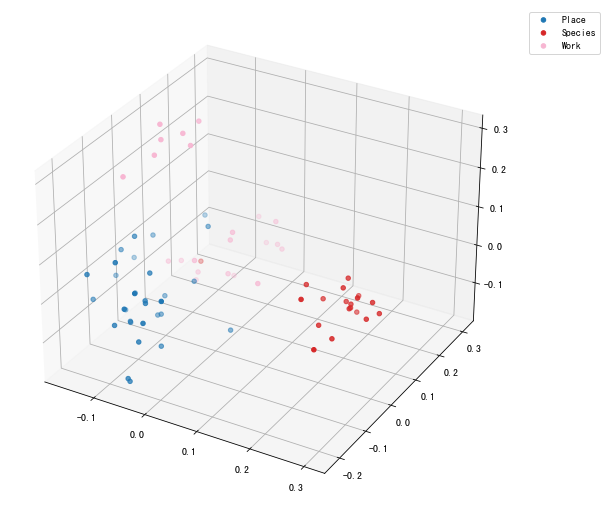

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8))
cmap = plt.get_cmap("tab20")
categories = sorted(cdf.l1.unique())

# 分别绘制每个类别
for i, cat in enumerate(categories):
    sub_matrix = np.array(cdf[cdf.l1 == cat]["embed_vis"].to_list())
    x=sub_matrix[:, 0]
    y=sub_matrix[:, 1]
    z=sub_matrix[:, 2]
    colors = [cmap(i/len(categories))] * len(sub_matrix)
    ax.scatter(x, y, z, c=colors, label=cat)

ax.legend(bbox_to_anchor=(1.2, 1))
plt.show();

&emsp;&emsp;可以比较明显的看出，三个不同类型的数据分别在不同的位置。

### 3.3 推荐

&emsp;&emsp;我们在很多APP或网站上都能看到推荐功能。比如在购物网站，每当你登陆或者选购一件商品后，系统就会给你推荐一些相关的产品。在这一小节中，我们就来做一个类似的应用，不过我们推荐的不是商品，而是文本，比如帖子、文章、新闻等。

&emsp;&emsp;我们以新闻为例，先说一下基本逻辑：

- 首先要有一个基础的文章库，可能包括标题、内容、标签等。
- 计算已有文章的Embedding并存储。
- 根据用户浏览记录，推荐和浏览记录最相似的文章。

&emsp;&emsp;使用如下的数据集：[AG News Classification Dataset | Kaggle](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset?select=train.csv)

&emsp;&emsp;看起来好像和前面的QA差不多，事实也的确如此，因为它们本质上都是相似匹配问题。只不过QA使用的是用户的Question去匹配已有知识库，而推荐是使用用户的浏览记录去匹配。但是很明显，推荐相比QA要更复杂一些，主要包括以下几个方面：

- 刚开始用户没有记录时的推荐（一般行业称为冷启动问题）。
- 除了相似还有其他要考虑的因素：比如热门内容、新内容、内容多样性、随时间变化的兴趣变化等等。
- 编码（Embedding输入）问题：我们应该取标题呢，还是文章，还是简要描述或者摘要，还是都要计算。
- 规模问题：推荐面临的量级一般会远超QA，除了横向扩展机器，是否能从流程和算法设计上提升效率。
- 用户反馈对推荐系统的影响问题：用户反感或喜欢与文章本身并没有直接关系，比如用户喜欢体育新闻但讨厌中国足球。
- 线上实时更新问题。

&emsp;&emsp;当然，一个完整的线上系统要考虑的因素可能更多。我们给大家列出这些只是希望读者在设计一个方案时能够充分调研和考虑，同时结合实际情况进行。反过来说，可能并不需要考虑上面的每个因素。所以，大家在实际操作时一定要活学活用，充分理解需求后再动手实施。

&emsp;&emsp;我们这里综合考虑上面的因素给大家一个比较简单的方案，但务必注意，其中每个模块的方案都不是唯一的。整体设计如下：

- 用户注册登录时，让其选择感兴趣的类型（如体育、音乐、时尚等），我们通过这一步将用户框在一个大的范围内，同时用来顺道解决冷启动问题。
- 给用户推荐内容时，在知道类别（用户注册时选择+浏览记录）后，应依次考虑时效性、热门程度、多样性等。
- 考虑到性能问题，可以编码「标题+摘要」。
- 对大类别进一步细分，只在细分类别里进行相似度计算。
- 记录用户实时行为（如浏览Item、浏览时长、评论、收藏、点赞、转发等）。
- 动态更新内容库，更新用户行为库。

&emsp;&emsp;在具体实施时，我们使用最常用的流程线方案：召回+排序。

- 召回：通过各种不同属性或特征（如用户偏好、热点、行为等）先找到一批要推荐列表。
- 排序：根据多样性、时效性、用户反馈、热门程度等属性对结果进行排序。

In [1]:
from dataclasses import dataclass
import pandas as pd

In [2]:
df = pd.read_csv("./dataset/AG_News.csv")
df.shape

(120000, 3)

In [3]:
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [21]:
df["Class Index"].value_counts()

3    30000
4    30000
2    30000
1    30000
Name: Class Index, dtype: int64

&emsp;&emsp;根据数据集介绍（上面的链接），四个类型分别是：1-World, 2-Sports, 3-Business, 4-Sci/Tech，每个类型有30000条数据，共12万条。接下来，我们将使用上面已经介绍的知识来做一个简单的流水线系统。

&emsp;&emsp;为了便于运行，依然取100条sample作为示例：

In [9]:
sdf = df.sample(100)

In [10]:
sdf["Class Index"].value_counts()

2    28
4    26
1    24
3    22
Name: Class Index, dtype: int64

&emsp;&emsp;首先维护一个用户偏好和行为记录：

In [35]:
from typing import List
@dataclass
class User:
    
    user_name: str

@dataclass
class UserPrefer:
    
    user_name: str
    prefers: List[int]


@dataclass
class Item:
    
    item_id: str
    item_props: dict


@dataclass
class Action:
    
    action_type: str
    action_props: dict


@dataclass
class UserAction:
    
    user: User
    item: Item
    action: Action
    action_time: str

In [232]:
u1 = User("u1")
up1 = UserPrefer("u1", [1, 2])
# sdf.iloc[1] 正好是sport（类别为2）
i1 = Item("i1", {
    "id": 1, 
    "catetory": "sport",
    "title": "Swimming: Shibata Joins Japanese Gold Rush", 
    "description": "\
    ATHENS (Reuters) - Ai Shibata wore down French teen-ager  Laure Manaudou to win the women's 800 meters \
    freestyle gold  medal at the Athens Olympics Friday and provide Japan with  their first female swimming \
    champion in 12 years.", 
    "content": "content"
})
a1 = Action("浏览", {
    "open_time": "2023-04-01 12:00:00", 
    "leave_time": "2023-04-01 14:00:00",
    "type": "close",
    "duration": "2hour"
})
ua1 = UserAction(u1, i1, a1, "2023-04-01 12:00:00")

&emsp;&emsp;计算所有文本的Embedding，这一步和之前一样：

In [77]:
from openai.embeddings_utils import get_embedding, cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
import openai
import numpy as np

OPENAI_API_KEY = "填入专属的API key"
openai.api_key = OPENAI_API_KEY

In [16]:
sdf["embedding"] = sdf.apply(lambda x: 
                             get_embedding(x.Title + x.Description, engine="text-embedding-ada-002"), axis=1)

&emsp;&emsp;我们先处理一下召回：

In [214]:
import random
class Recall:
    
    def __init__(self, df: pd.DataFrame):
        self.data = df
    
    def user_prefer_recall(self, user, n):
        up = self.get_user_prefers(user)
        idx = random.randrange(0, len(up.prefers))
        return self.pick_by_idx(idx, n)
    
    def hot_recall(self, n):
        # 随机进行示例
        df = self.data.sample(n)
        return df
    
    def user_action_recall(self, user, n):
        actions = self.get_user_actions(user)
        interest = self.get_most_interested_item(actions)
        recoms = self.recommend_by_interest(interest, n)
        return recoms
    
    def get_most_interested_item(self, user_action):
        """
        可以选近一段时间内用户交互时间、次数、评论（相关属性）过的Item
        """
        # 就是sdf的第2行，idx为1的那条作为最喜欢（假设）
        # 是一条游泳相关的Item
        idx = user_action.item.item_props["id"]
        im = self.data.iloc[idx]
        return im
    
    def recommend_by_interest(self, interest, n):
        cate_id = interest["Class Index"]
        q_emb = interest["embedding"]
        # 确定类别
        base = self.data[self.data["Class Index"] == cate_id]
        # 此处可以复用QA那一段代码，用给定embedding计算base中embedding的相似度
        base_arr = np.array(
            [v.embedding for v in base.itertuples()]
        )
        q_arr = np.expand_dims(q_emb, 0)
        sims = cosine_similarity(base_arr, q_arr)
        # 排除掉自己
        idxes = sims.argsort(0).squeeze()[-(n+1):-1]
        return base.iloc[reversed(idxes.tolist())]
    
    def pick_by_idx(self, category, n):
        df = self.data[self.data["Class Index"] == category]
        return df.sample(n)
    
    def get_user_actions(self, user):
        dct = {"u1": ua1}
        return dct[user.user_name]
    
    def get_user_prefers(self, user):
        dct = {"u1": up1}
        return dct[user.user_name]
    
    def run(self, user):
        ur = self.user_action_recall(user, 5)
        if len(ur) == 0:
            ur = self.user_prefer_recall(user, 5)
        hr = self.hot_recall(3)
        return pd.concat([ur, hr], axis=0)

In [224]:
r = Recall(sdf)

In [225]:
rd = r.run(u1)

In [227]:
# 共8个，5个用户行为推荐、3个热门
rd

,Class Index,Title,Description,embedding
12120,2,Olympics Wrap: Another Doping Controversy Surf...,ATHENS (Reuters) - Olympic chiefs ordered Hun...,"[0.013697294518351555, 0.012140628881752491, 0..."
5905,2,Saturday Night #39;s Alright for Blighty,"Matthew Pinsents coxless four team, sailor Ben...","[-0.012345104478299618, -0.0025237693917006254..."
29729,2,Beijing Paralympic Games to be fabulous: IPC P...,The 13th Summer Paralympic Games in 2008 in Be...,"[-0.009852061048150063, 0.017894696444272995, ..."
27215,2,Dent tops Luczak to win at China Open,Taylor Dent defeated Australian qualifier Pete...,"[-0.004778657108545303, 0.014275987632572651, ..."
72985,2,Rusedski through in St Petersburg,Greg Rusedski eased into the second round of t...,"[-0.007127437274903059, 0.0025771241635084152,..."
28344,3,Delta pilots wary of retirements,Union says pilots may retire en masse to get p...,"[-0.03769957274198532, -0.032835111021995544, ..."
80374,2,Everett powerless in loss to Prince George,"Besides the final score, there is only one sta...","[-0.014837506227195263, -0.015726948156952858,..."
64648,4,New Screening Technology Is Nigh,Machines built to find weapons hidden in cloth...,"[-0.020757483318448067, -0.017689339816570282,..."


&emsp;&emsp;需要再次说明的是，上面的只是一个大致的流程，实际中有很多细节或优化点需要注意，比如：

- 建数据库表（上面的`get_`其实都是查表）
- 将Item、User和Action也进行Embedding，全部使用Embedding后再做召回
- 对『感兴趣`get_most_interested_item`』更多的优化，考虑更多行为和反馈，召回更多不同类型条目
- 性能和自动更新数据的考虑
- 线上评测，A/B等

&emsp;&emsp;可以发现，我们虽然只做了召回一步，但其中涉及到的内容已经远远不止之前QA那一点了，QA用到的东西可能只是其中一小部分。不过事无绝对，即便是QA任务也可能根据实际情况不同需要做很多优化，比如召回+排序。但总体来说，类似推荐这样比较综合的系统相对来说会更加复杂一些。

&emsp;&emsp;后面就是排序了，这一步需要区分不同的应用场景，可以做或不做，做的话（就是对刚刚得到的列表进行排序）也可以简单或复杂。比如简单地按发布时间，复杂的综合考虑多样性、时效性、用户反馈、热门程度等多种属性。具体操作时，可以直接按相关属性排序，也可以用模型排序。这里就不再继续深入了。

## 相关文献

- 【1】[浅析文本分类 —— 情感分析与自然语言处理 | Yam](https://yam.gift/2021/10/27/NLP/2021-10-27-Senta/)
- 【2】[句子表征综述 | Yam](https://yam.gift/2022/03/27/NLP/2022-03-27-Sentence-Representation-Summarization/)
- 【3】[NLP 表征的历史与未来 | Yam](https://yam.gift/2020/12/12/NLP/2020-12-12-NLP-Representation-History-Future/)


memo：

- [openai-cookbook/Semantic_text_search_using_embeddings.ipynb at main · openai/openai-cookbook](https://github.com/openai/openai-cookbook/blob/main/examples/Semantic_text_search_using_embeddings.ipynb)
- [openai-cookbook/getting-started-with-redis-and-openai.ipynb at main · openai/openai-cookbook](https://github.com/openai/openai-cookbook/blob/main/examples/vector_databases/redis/getting-started-with-redis-and-openai.ipynb)
- [openai-cookbook/Visualizing_embeddings_in_3D.ipynb at main · openai/openai-cookbook](https://github.com/openai/openai-cookbook/blob/main/examples/Visualizing_embeddings_in_3D.ipynb)

注①：感谢DataWhale成员于沼懿指出此处不严谨描述。